In [7]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import models.training as tr
import models.reportnet as M

# ChestX-Ray data

In [1]:
# Load data
reports = pr.reports
projections = pr.projections

uids = np.unique(projections.index)
uids = np.random.choice(uids, 10, replace=False)
train_data, train_loader, val_data, val_loader, test_data, test_loader = pr.create_dataloaders(uids, projections, reports, pr.IMAGES_PATH)
vocab_size = len(train_data.vocab.union(val_data.vocab))

# Get reports as text sequences
train_reports = pr.get_sequences(train_data, train_data.word2idx['</s>'], train_data.word2idx['<pad>'])
val_reports = pr.get_sequences(val_data, val_data.word2idx['</s>'], val_data.word2idx['<pad>'])

[nltk_data] Downloading package punkt to /home/mdelucasg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# ReportNet (our model from scratch)

## CNN

In [2]:
from torchsummary import summary
model = M.CNN()
summary(model, (1, 2048, 2048))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 12, 2048, 2048]             120
       BatchNorm2d-2       [-1, 12, 2048, 2048]              24
         AvgPool2d-3       [-1, 12, 1024, 1024]               0
            Conv2d-4       [-1, 24, 1024, 1024]           2,616
       BatchNorm2d-5       [-1, 24, 1024, 1024]              48
         AvgPool2d-6         [-1, 24, 512, 512]               0
            Conv2d-7         [-1, 48, 512, 512]          10,416
       BatchNorm2d-8         [-1, 48, 512, 512]              96
         AvgPool2d-9         [-1, 48, 256, 256]               0
           Conv2d-10         [-1, 96, 256, 256]          41,568
      BatchNorm2d-11         [-1, 96, 256, 256]             192
        AvgPool2d-12         [-1, 96, 128, 128]               0
           Conv2d-13        [-1, 192, 128, 128]         166,080
      BatchNorm2d-14        [-1, 192, 1

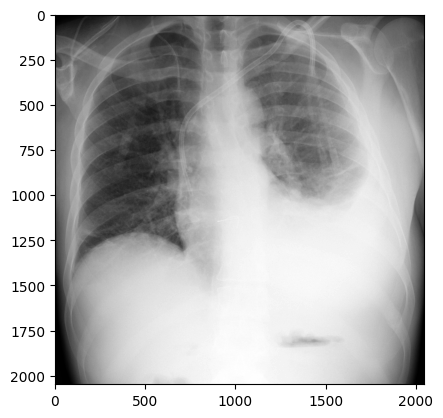

In [3]:
img = train_data[0][0]

import matplotlib.pyplot as plt
plt.imshow(img.squeeze(), cmap='gray')

In [9]:
model = M.CNN()
img = train_data[0][0]
img_tensor = pr.img2tensor(img)
img_features = model(img_tensor)
print(f"Image features shape: {img_features.shape}")

Image features shape: torch.Size([1, 256])


In [10]:
imf = img_features.squeeze().detach()
imf

tensor([-0.2739, -0.0646,  0.0296,  0.1004, -0.3708,  0.0064, -0.2207,  0.0199,
         0.0649,  0.0175,  0.1301,  0.0432, -0.1985,  0.1859, -0.1280,  0.1095,
         0.1120,  0.1730,  0.0380, -0.0686, -0.1015,  0.0137,  0.2825,  0.0742,
        -0.1197,  0.0015, -0.0856,  0.2514,  0.4004,  0.1864, -0.0386, -0.0080,
         0.2369, -0.0347, -0.1765,  0.0272,  0.0425, -0.0842,  0.3329, -0.0324,
        -0.0971, -0.0482,  0.1318, -0.0126, -0.1259,  0.0097,  0.0113,  0.0890,
         0.1336, -0.0552,  0.1004, -0.0967,  0.1717,  0.0010, -0.1240,  0.1450,
         0.1444, -0.1310,  0.3099, -0.1277,  0.0630, -0.2069, -0.0398, -0.0774,
         0.1497,  0.0066,  0.2485,  0.0068,  0.0919, -0.0256,  0.0589,  0.1638,
        -0.0563,  0.3309,  0.1938,  0.0820,  0.0351, -0.0581, -0.0715, -0.0128,
         0.0944,  0.1113,  0.0136, -0.0120,  0.1569, -0.3048, -0.2275, -0.0878,
         0.1516, -0.0514, -0.1834, -0.2355, -0.0405, -0.0573,  0.0335, -0.0933,
        -0.1251,  0.0753,  0.2377, -0.01

## Training Transformer

In [12]:
# Training
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=train_data.word2idx['<pad>'])

transformer = M.Transformer(
    num_tokens=1000,
    dim_model=1000*2,
    num_heads=2,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout_p=0.3,
)

tr.predict(transformer, imf)


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

## Training

## Multimodality

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = M.ReportNet(vocab_size=vocab_size).to(device)
summary(model, [(1, 2048, 2048), (train_data[0][2])], batch_size=1)

NameError: name 'torch' is not defined

In [ ]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        image1, image2, report = batch

        # Forward pass
        output = model(image1, image2)

        # Compute loss
        loss = loss_fn(output.view(-1, output.size(-1)), report.view(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    train_loss = train(model, train_data, loss_fn, optimizer, device)
    print(f'Epoch: {epoch + 1}, Train loss: {train_loss}')
